# CNN + MaxPool
Fixed train/valid split.
Combine train+test in one. 
Put this in a loop of 10.
Canon, MCC.

In [11]:
from datetime import datetime
print(datetime.now())

2023-03-11 22:12:20.738665


In [12]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [13]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=12
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

Python 3.9.16
sklearn 1.2.1


In [14]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
SEQUENCE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
RCI_FILE_TEST  = 'test.lncRNA_RCI.csv'
SEQUENCE_TEST  = 'test.canon_lncRNA_transcripts.csv'
CNN_FILE       = 'cnn_235.model'
GMM_FILE       = 'gmm_235.pickle'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [15]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [16]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        gene_to_rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [17]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [18]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-11 22:12:22.815547
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4997, 4)           1028      
                                                                 
 conv1d_2 (Conv1D)           (None, 4982, 64)          4160      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 621, 64)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 39744)             0         
                                                                 
 dense_4 (Dense)             (None, 16)                635920    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                           

## Training

In [19]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def _get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index, exclude_middle=False):
        # gene_index is ndarray with subset of indices of all_genes
        subsetX=[]
        subsetY=[]
        gene_subset = self._get_gene_subset(gene_index)
        for t in range(len(self.all_ids)):
            gene_id,tran_id = self.all_ids[t]
            if gene_id in gene_subset:
                oneX            = self.all_seqs[t]
                oneY            = self.rci_map[gene_id]
                if exclude_middle and oneY >= -2 and oneY <= 0:
                    # Exclude middle from train set only, for comparison to Yuan et al
                    continue
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:
                # assume prior call to load_gmm()
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_without_validation(self):
        print(datetime.now())
        # for final train, the train subset is the entire data set
        train_index = range(len(self.all_ids))  
        X_train,y_rci = self._get_X_y(train_index) 
        self._prepare_threshold(y_rci,True)  # create and save
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        y_rci = None
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 

        # for final train, there is no separate valid set
        X_valid = X_train   
        y_valid = y_train
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_valid, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
        self._show_sizes('Train',y_valid)
        self._show_sizes('Predict',yhat_classes)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_valid, yhat_classes)*100.
        precision = precision_score(y_valid, yhat_classes)*100.
        recall = recall_score(y_valid, yhat_classes)*100.
        f1 = f1_score(y_valid, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
        mcc = matthews_corrcoef(y_valid, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_valid,yhat_pred,prc_X,prc_Y)
        print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
        print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
        print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)
        
    def test_without_training(self):
        print(datetime.now())
        # for final train, the train subset is the entire data set
        train_index = range(len(self.all_ids))  
        X_train,y_rci = self._get_X_y(train_index) 
        self._prepare_threshold(y_rci,False)  # reload
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        y_rci = None
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}

        # for final test, do no train
        # assume load_cnn) has been called

        # for final test, there is no separate valid set
        X_valid = X_train   
        y_valid = y_train
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_valid, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
        self._show_sizes('Train',y_valid)
        self._show_sizes('Predict',yhat_classes)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_valid, yhat_classes)*100.
        precision = precision_score(y_valid, yhat_classes)*100.
        recall = recall_score(y_valid, yhat_classes)*100.
        f1 = f1_score(y_valid, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
        mcc = matthews_corrcoef(y_valid, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_valid,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def load_cnn(self,filename):
        self.model = keras.models.load_model(filename)
        
    def load_gmm(self,filename):
        gmm = pickle.load(open(filename,'rb'))
        self.discriminator = gmm
        
    def save_cnn(self,filename):
        self.model.save(filename)
        
    def save_gmm(self,filename):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            pickle.dump(gmm, open(filename,'wb'))
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

2023-03-11 22:12:23.280992
Loading...
2023-03-11 22:12:23.281510
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 0
2023-03-11 22:12:28.764791
2023-03-11 22:12:28.765725
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:12:32.068410
Epoch 1/12
133/133 [==============================] - 4s 11ms/step - loss: 0.7134 - accuracy: 0.5031
Epoch 2/12
133/133 [==============================] - 1s 10ms/step - loss: 0.7011 - accuracy: 0.4627
Epoch 3/12
133/133 [==============================] - 1s 11ms/step - loss: 0.6901 - accuracy: 0.5238
Epoch 4/12
133/133 [==============================] - 2s 12ms/step - loss: 0.6679 - accuracy: 0.5630
Epoch 5/12
133/133 [==============================] - 2s 12ms/step - loss: 0.6144 - accuracy: 0.6416
Epoch 6/12


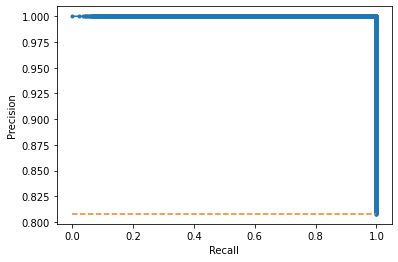

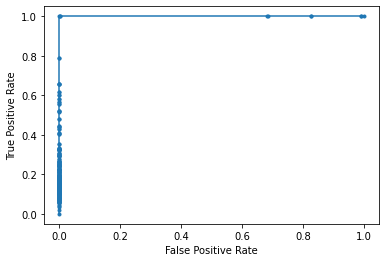

Accuracy: 99.95% Precision: 100.00% Recall: 99.94%
F1: 99.97% MCC: 1.00%
AUPRC: 99.99% AUROC: 99.97%



Loading...
2023-03-11 22:12:56.963265
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 0
2023-03-11 22:13:00.330490
2023-03-11 22:13:00.941286
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:13:01.453106
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 893:160 84.81%
Valid sizes (1053, 4997) (1053,)
Range of scores: 6.750432e-05 to 1.0
Score threshold 0.5


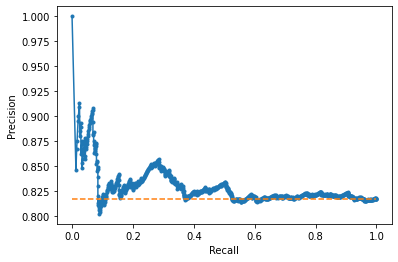

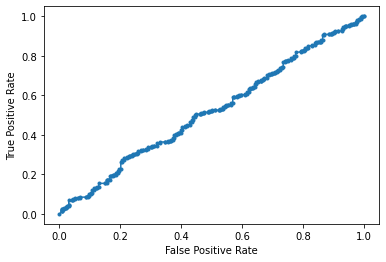

Accuracy: 72.74% Precision: 82.08% Recall: 85.23%
F1: 83.63% MCC: 0.03%
AUPRC: 82.98% AUROC: 51.93%
 accuracy [72.74453941120608]
 precision [82.0828667413214]
 recall [85.23255813953489]
 F1 [83.62806617227609]
 MCC [0.025123788506031447]
 AUPRC [82.98447556596416]
 AUROC [51.9276418845644]
Loading...
2023-03-11 22:13:02.266435
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 1
2023-03-11 22:13:07.689129
2023-03-11 22:13:07.689705
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:13:10.531270
Epoch 1/12
133/133 [==============================] - 4s 14ms/step - loss: 0.7270 - accuracy: 0.4917
Epoch 2/12
133/133 [==============================] - 2s 13ms/step - loss: 0.6975 - accuracy: 0.5300
Epoch 3/12
133/133 [============================

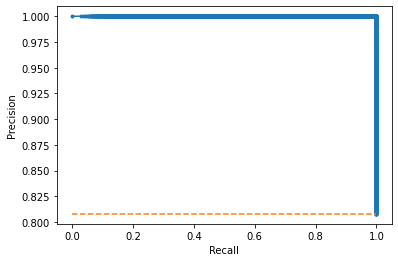

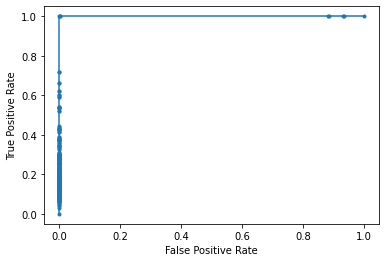

Accuracy: 99.95% Precision: 100.00% Recall: 99.94%
F1: 99.97% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:13:33.293625
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 1
2023-03-11 22:13:34.639647
2023-03-11 22:13:35.063153
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:13:35.346379
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 895:158 85.00%
Valid sizes (1053, 4997) (1053,)
Range of scores: 0.0002052506 to 1.0
Score threshold 0.5


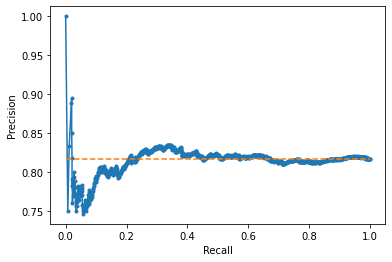

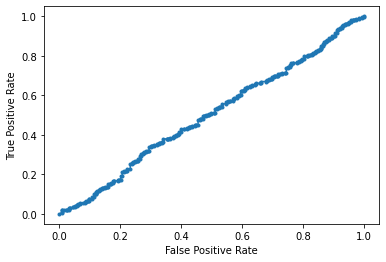

Accuracy: 71.79% Precision: 81.45% Recall: 84.77%
F1: 83.08% MCC: -0.01%
AUPRC: 81.47% AUROC: 50.23%
 accuracy [71.7948717948718]
 precision [81.45251396648044]
 recall [84.76744186046513]
 F1 [83.07692307692307]
 MCC [-0.01346577292749242]
 AUPRC [81.46571250255195]
 AUROC [50.23496806844199]
Loading...
2023-03-11 22:13:35.962773
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 2
2023-03-11 22:13:41.788993
2023-03-11 22:13:41.790618
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:13:48.350821
Epoch 1/12
133/133 [==============================] - 3s 11ms/step - loss: 0.7082 - accuracy: 0.5087
Epoch 2/12
133/133 [==============================] - 1s 10ms/step - loss: 0.6963 - accuracy: 0.5144
Epoch 3/12
133/133 [==========================

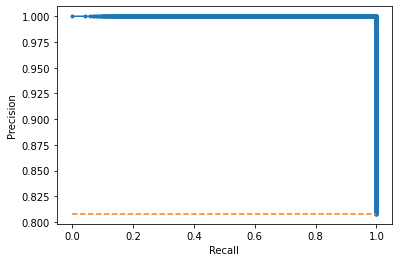

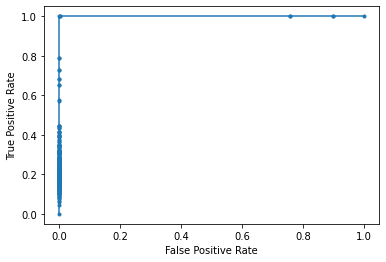

Accuracy: 99.93% Precision: 100.00% Recall: 99.91%
F1: 99.96% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:14:12.845501
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 2
2023-03-11 22:14:14.219505
2023-03-11 22:14:14.625924
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:14:14.895786
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 921:132 87.46%
Valid sizes (1053, 4997) (1053,)
Range of scores: 1.6713948e-06 to 1.0
Score threshold 0.5


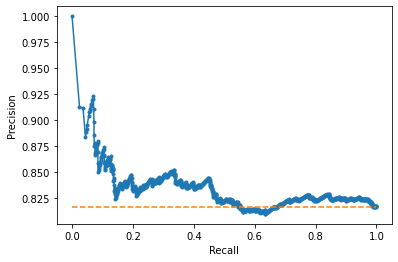

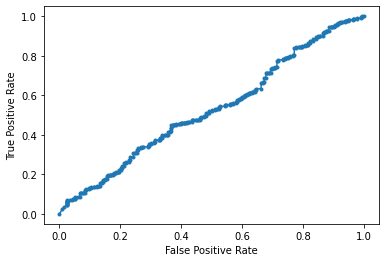

Accuracy: 75.21% Precision: 82.52% Recall: 88.37%
F1: 85.35% MCC: 0.06%
AUPRC: 83.71% AUROC: 53.05%
 accuracy [75.21367521367522]
 precision [82.51900108577634]
 recall [88.37209302325581]
 F1 [85.34531162268388]
 MCC [0.05786649219760825]
 AUPRC [83.70769022042022]
 AUROC [53.04524641523075]
Loading...
2023-03-11 22:14:15.522306
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 3
2023-03-11 22:14:24.896974
2023-03-11 22:14:24.898081
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:14:27.773805
Epoch 1/12
133/133 [==============================] - 3s 11ms/step - loss: 0.7185 - accuracy: 0.4816
Epoch 2/12
133/133 [==============================] - 1s 10ms/step - loss: 0.6953 - accuracy: 0.5005
Epoch 3/12
133/133 [===========================

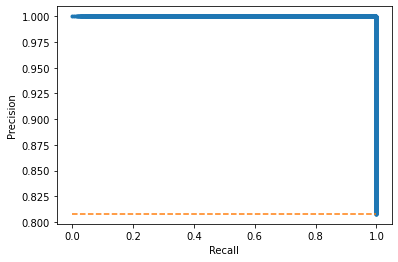

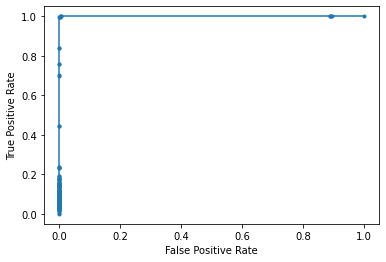

Accuracy: 96.55% Precision: 100.00% Recall: 95.73%
F1: 97.82% MCC: 0.90%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:14:49.899734
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 3
2023-03-11 22:14:53.560435
2023-03-11 22:14:54.266587
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:14:54.767776
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 787:266 74.74%
Valid sizes (1053, 4997) (1053,)
Range of scores: 1.7388229e-05 to 1.0
Score threshold 0.5


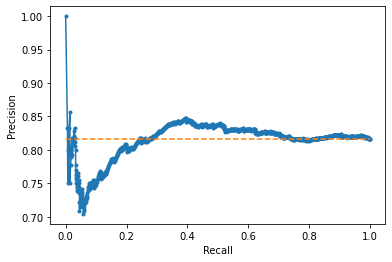

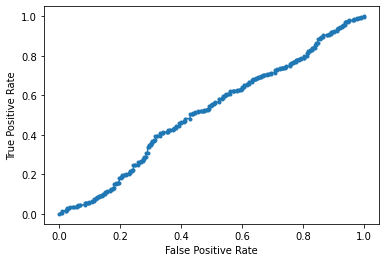

Accuracy: 65.72% Precision: 81.70% Recall: 74.77%
F1: 78.08% MCC: 0.00%
AUPRC: 81.50% AUROC: 51.74%
 accuracy [65.71699905033238]
 precision [81.70266836086404]
 recall [74.76744186046511]
 F1 [78.08136004857317]
 MCC [0.0013894524838106831]
 AUPRC [81.49972385524576]
 AUROC [51.74418604651163]
Loading...
2023-03-11 22:14:55.383192
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 4
2023-03-11 22:15:00.878812
2023-03-11 22:15:00.879915
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:15:03.588484
Epoch 1/12
133/133 [==============================] - 3s 12ms/step - loss: 0.7121 - accuracy: 0.4889
Epoch 2/12
133/133 [==============================] - 1s 11ms/step - loss: 0.6997 - accuracy: 0.5123
Epoch 3/12
133/133 [=========================

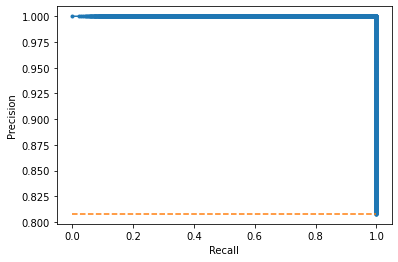

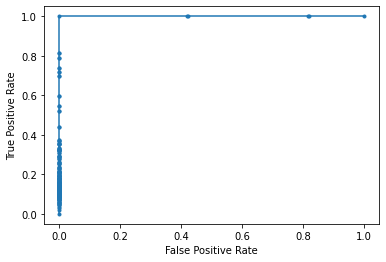

Accuracy: 99.91% Precision: 100.00% Recall: 99.88%
F1: 99.94% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:15:25.935003
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 4
2023-03-11 22:15:27.236205
2023-03-11 22:15:27.647789
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:15:27.913486
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 916:137 86.99%
Valid sizes (1053, 4997) (1053,)
Range of scores: 0.0002663148 to 1.0
Score threshold 0.5


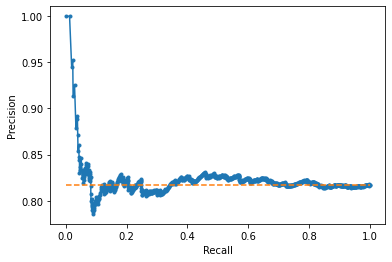

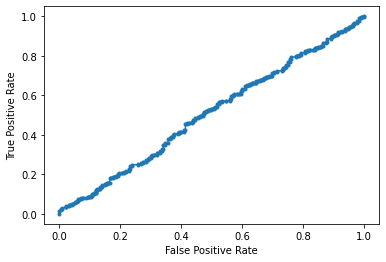

Accuracy: 73.22% Precision: 81.55% Recall: 86.86%
F1: 84.12% MCC: -0.01%
AUPRC: 82.42% AUROC: 50.82%
 accuracy [73.21937321937322]
 precision [81.55021834061135]
 recall [86.86046511627907]
 F1 [84.12162162162163]
 MCC [-0.008099880480914357]
 AUPRC [82.42123283330949]
 AUROC [50.81726714061935]
Loading...
2023-03-11 22:15:28.945221
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 5
2023-03-11 22:15:36.454950
2023-03-11 22:15:36.455921
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:15:39.345975
Epoch 1/12
133/133 [==============================] - 3s 11ms/step - loss: 0.7064 - accuracy: 0.4790
Epoch 2/12
133/133 [==============================] - 1s 11ms/step - loss: 0.7051 - accuracy: 0.4934
Epoch 3/12
133/133 [========================

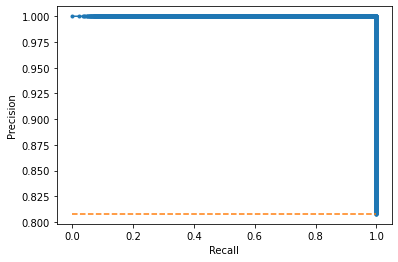

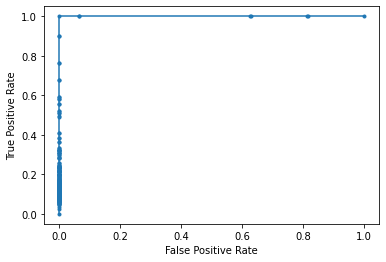

Accuracy: 99.74% Precision: 100.00% Recall: 99.68%
F1: 99.84% MCC: 0.99%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:16:02.194741
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 5
2023-03-11 22:16:03.562436
2023-03-11 22:16:03.967808
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:16:04.245361
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 851:202 80.82%
Valid sizes (1053, 4997) (1053,)
Range of scores: 5.1439715e-06 to 1.0
Score threshold 0.5


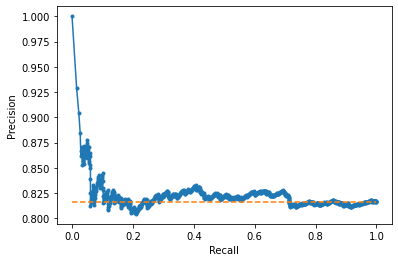

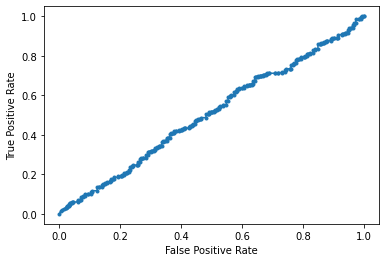

Accuracy: 69.33% Precision: 81.55% Recall: 80.70%
F1: 81.12% MCC: -0.01%
AUPRC: 82.45% AUROC: 50.75%
 accuracy [69.32573599240266]
 precision [81.55111633372502]
 recall [80.69767441860465]
 F1 [81.12215078901227]
 MCC [-0.006381906188681644]
 AUPRC [82.45120192166236]
 AUROC [50.75400650680805]
Loading...
2023-03-11 22:16:04.998533
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 6
2023-03-11 22:16:10.416323
2023-03-11 22:16:10.417254
Discriminator is GMM
Means [-0.2239477097586747, 1.9719112416941393]
Variances [7.95766867 2.55796695]
Priors [0.35126894 0.64873106]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:16:15.358906
Epoch 1/12
133/133 [==============================] - 3s 11ms/step - loss: 0.7086 - accuracy: 0.4740
Epoch 2/12
133/133 [==============================] - 1s 11ms/step - loss: 0.6981 - accuracy: 0.5024
Epoch 3/12
133/133 [========================

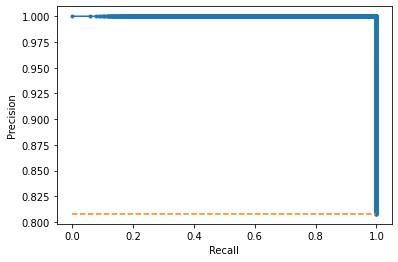

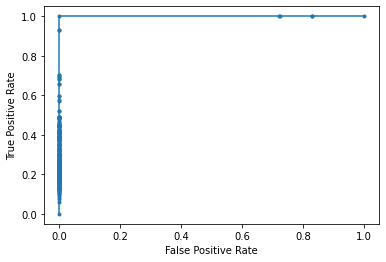

Accuracy: 99.98% Precision: 100.00% Recall: 99.97%
F1: 99.99% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:16:40.239401
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 6
2023-03-11 22:16:43.151346
2023-03-11 22:16:43.684504
Discriminator is GMM
Means [-0.2239477097586747, 1.9719112416941393]
Variances [7.95766867 2.55796695]
Priors [0.35126894 0.64873106]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:16:43.976387
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 924:129 87.75%
Valid sizes (1053, 4997) (1053,)
Range of scores: 5.118038e-07 to 1.0
Score threshold 0.5


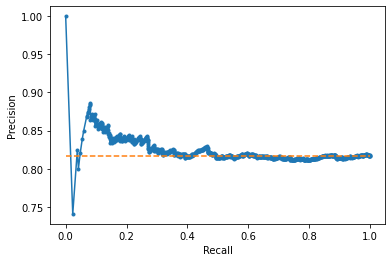

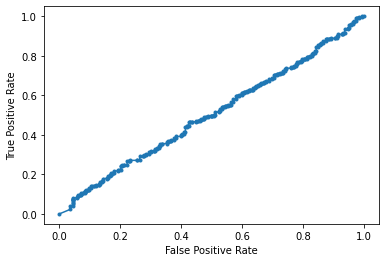

Accuracy: 73.98% Precision: 81.71% Recall: 87.79%
F1: 84.64% MCC: 0.00%
AUPRC: 82.45% AUROC: 50.49%
 accuracy [73.97910731244065]
 precision [81.70995670995671]
 recall [87.79069767441861]
 F1 [84.64125560538116]
 MCC [0.002666076131697951]
 AUPRC [82.45035333777484]
 AUROC [50.494035425954934]
Loading...
2023-03-11 22:16:44.729920
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 7
2023-03-11 22:16:50.164130
2023-03-11 22:16:50.165104
Discriminator is GMM
Means [-0.2239477097586747, 1.9719112416941393]
Variances [7.95766867 2.55796695]
Priors [0.35126894 0.64873106]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:16:52.869215
Epoch 1/12
133/133 [==============================] - 4s 12ms/step - loss: 0.7085 - accuracy: 0.4540
Epoch 2/12
133/133 [==============================] - 1s 11ms/step - loss: 0.6968 - accuracy: 0.5257
Epoch 3/12
133/133 [=========================

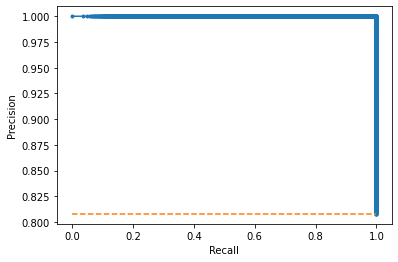

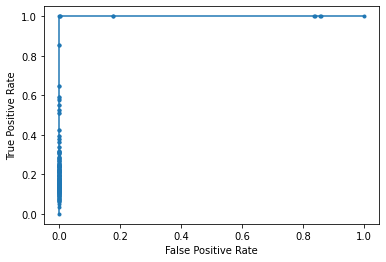

Accuracy: 99.88% Precision: 100.00% Recall: 99.85%
F1: 99.93% MCC: 1.00%
AUPRC: 100.00% AUROC: 99.99%



Loading...
2023-03-11 22:17:16.872616
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 7
2023-03-11 22:17:18.208106
2023-03-11 22:17:18.644231
Discriminator is GMM
Means [-0.2239477097586747, 1.9719112416941393]
Variances [7.95766867 2.55796695]
Priors [0.35126894 0.64873106]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:17:18.917383
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 874:179 83.00%
Valid sizes (1053, 4997) (1053,)
Range of scores: 9.2114993e-07 to 1.0
Score threshold 0.5


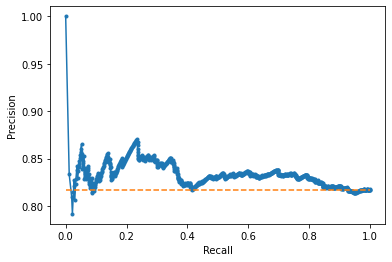

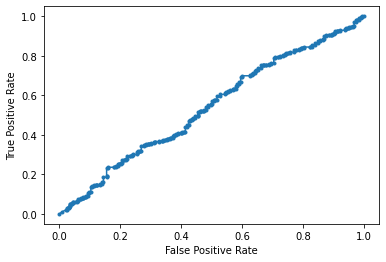

Accuracy: 72.27% Precision: 82.49% Recall: 83.84%
F1: 83.16% MCC: 0.05%
AUPRC: 83.37% AUROC: 54.02%
 accuracy [72.26970560303894]
 precision [82.49427917620137]
 recall [83.83720930232558]
 F1 [83.16032295271049]
 MCC [0.04699566992786749]
 AUPRC [83.36579452071679]
 AUROC [54.02458127485239]
Loading...
2023-03-11 22:17:19.510790
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 8
2023-03-11 22:17:26.779871
2023-03-11 22:17:26.780568
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:17:29.494354
Epoch 1/12
133/133 [==============================] - 3s 12ms/step - loss: 0.7103 - accuracy: 0.5382
Epoch 2/12
133/133 [==============================] - 2s 12ms/step - loss: 0.6992 - accuracy: 0.4924
Epoch 3/12
133/133 [===========================

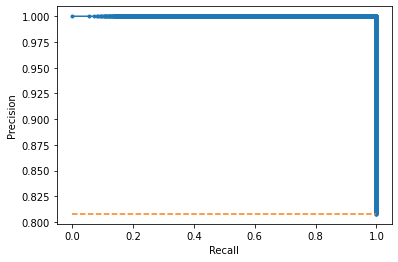

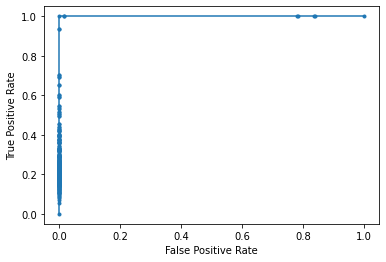

Accuracy: 99.98% Precision: 100.00% Recall: 99.97%
F1: 99.99% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:17:52.422606
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 8
2023-03-11 22:17:54.482977
2023-03-11 22:17:54.900530
Discriminator is GMM
Means [1.9719112416941393, -0.2239477097586747]
Variances [2.55796695 7.95766867]
Priors [0.64873106 0.35126894]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:17:55.170012
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 905:148 85.94%
Valid sizes (1053, 4997) (1053,)
Range of scores: 9.532787e-05 to 1.0
Score threshold 0.5


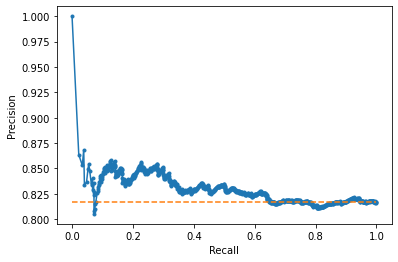

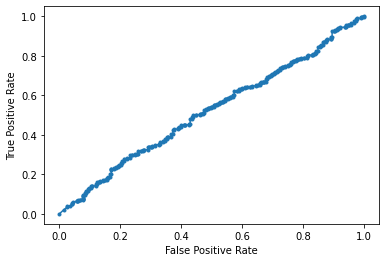

Accuracy: 72.55% Precision: 81.55% Recall: 85.81%
F1: 83.63% MCC: -0.01%
AUPRC: 83.15% AUROC: 52.14%
 accuracy [72.55460588793922]
 precision [81.54696132596685]
 recall [85.81395348837209]
 F1 [83.62606232294618]
 MCC [-0.007954294414375717]
 AUPRC [83.1502158069341]
 AUROC [52.1433305217496]
Loading...
2023-03-11 22:17:55.907902
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.

Training # 9
2023-03-11 22:18:01.372163
2023-03-11 22:18:01.373128
Discriminator is GMM
Means [-0.2239477097586747, 1.9719112416941393]
Variances [7.95766867 2.55796695]
Priors [0.35126894 0.64873106]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:18:05.681062
Epoch 1/12
133/133 [==============================] - 4s 12ms/step - loss: 0.7110 - accuracy: 0.4521
Epoch 2/12
133/133 [==============================] - 1s 11ms/step - loss: 0.6946 - accuracy: 0.5276
Epoch 3/12
133/133 [==========================

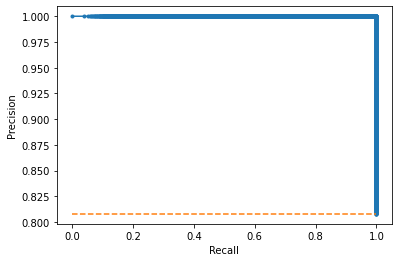

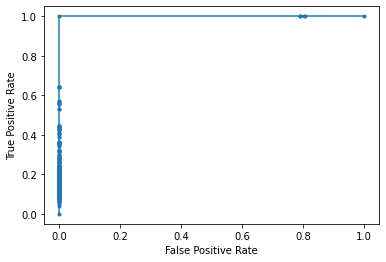

Accuracy: 99.98% Precision: 100.00% Recall: 99.97%
F1: 99.99% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:18:30.663559
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1053 sequences.

Testing # 9
2023-03-11 22:18:33.596436
2023-03-11 22:18:34.204041
Discriminator is GMM
Means [-0.2239477097586747, 1.9719112416941393]
Variances [7.95766867 2.55796695]
Priors [0.35126894 0.64873106]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:18:34.547338
train class weights 1:0  0.61: 2.73
Train 1:0 860:193 81.67%
Predict 1:0 886:167 84.14%
Valid sizes (1053, 4997) (1053,)
Range of scores: 3.9461244e-07 to 1.0
Score threshold 0.5


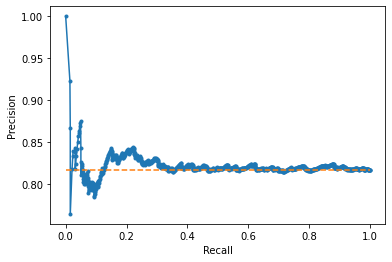

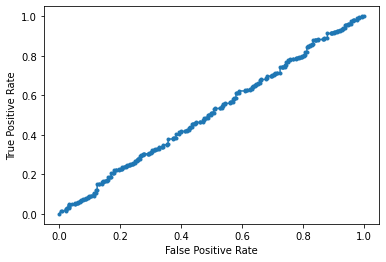

Accuracy: 72.46% Precision: 82.17% Recall: 84.65%
F1: 83.39% MCC: 0.03%
AUPRC: 82.31% AUROC: 51.09%
 accuracy [72.4596391263058]
 precision [82.16704288939052]
 recall [84.65116279069768]
 F1 [83.3906071019473]
 MCC [0.029506306458338197]
 AUPRC [82.3051346619914]
 AUROC [51.08928786600795]
2023-03-11 22:18:35.296555


In [20]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

for repeats in range(10):
    print("Loading...")
    print(datetime.now())
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TRAIN
    gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_TRAIN
    allids,allseq = loader.load_sequence(filepath)
    print('Loaded',len(allseq),'sequences.')
    loader = None  # drop K-mer cache to save RAM
    print()
    print("Training #",repeats)
    print(datetime.now())
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    cvdo.train_without_validation()
    filepath = DATA_DIR+GMM_FILE
    cvdo.save_gmm(filepath)
    filepath = DATA_DIR+CNN_FILE
    cvdo.save_cnn(filepath)

    print()
    print("Loading...")
    print(datetime.now())
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_TEST
    allids,allseq = loader.load_sequence(filepath)
    print('Loaded',len(allseq),'sequences.')
    loader = None  # drop K-mer cache to save RAM

    print()
    print("Testing #",repeats)
    print(datetime.now())
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    filepath = DATA_DIR+GMM_FILE
    cvdo.load_gmm(filepath)
    filepath = DATA_DIR+CNN_FILE
    cvdo.load_cnn(filepath)
    cvdo.test_without_training()
    cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
        cvdo.get_statistics()

    print(" accuracy" ,  cv_accuracy)
    print(" precision" , cv_precision)
    print(" recall" ,    cv_recall)
    print(" F1" ,        cv_f1)
    print(" MCC" ,       cv_mcc)
    print(" AUPRC" ,     cv_auprc)
    print(" AUROC" ,     cv_auroc)

    accuracy.append(cv_accuracy)
    precision.append(cv_precision)
    recall.append(cv_recall)
    f1.append(cv_f1)
    mcc.append(cv_mcc)
    auprc.append(cv_auprc)
    auroc.append(cv_auroc)
print(datetime.now())

In [22]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 71.93% std 2.66
 precision mean 81.88% std 0.41
 recall mean 84.28% std 3.98
 F1 mean 83.02% std 2.06
 MCC mean 0.01% std 0.03
 AUPRC mean 82.58% std 0.74
 AUROC mean 51.63% std 1.20
 accuracy [[72.74453941120608], [71.7948717948718], [75.21367521367522], [65.71699905033238], [73.21937321937322], [69.32573599240266], [73.97910731244065], [72.26970560303894], [72.55460588793922], [72.4596391263058]]
 precision [[82.0828667413214], [81.45251396648044], [82.51900108577634], [81.70266836086404], [81.55021834061135], [81.55111633372502], [81.70995670995671], [82.49427917620137], [81.54696132596685], [82.16704288939052]]
 recall [[85.23255813953489], [84.76744186046513], [88.37209302325581], [74.76744186046511], [86.86046511627907], [80.69767441860465], [87.79069767441861], [83.83720930232558], [85.81395348837209], [84.65116279069768]]
 F1 [[83.62806617227609], [83.07692307692307], [85.34531162268388], [78.08136004857317], [84.12162162162163], [81.12215078901227], [84.64125560